In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

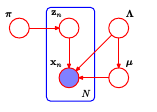

Fig.5 Directed acyclic graph representing the Bayesian mix- ture of Gaussians model, in which the box (plate) de- notes a set of N i.i.d. observations. Here µ denotes {µk } and Λ denotes {Λk }.
##  Illustration: Variational Mixture of Gaussians

In this section, we apply the variational inference technique to the Gaussian mixture model (GMM). The GMM is a generative model for a set of data points $ X = \{ x_1, \ldots, x_N \} $, where each observation $ x_n $ is assumed to come from one of $ K $ Gaussian distributions, and the latent variable $ z_n $ indicates which component the data point belongs to.

### Likelihood of the Data

The likelihood for each data point $ x_n $ is given by:

$$
p(x_n | \mu, \Lambda, z_n) = \mathcal{N}(x_n | \mu_{z_n}, \Lambda_{z_n}^{-1})
$$

Where:
- $ \mu_k $ is the mean of the $ k $-th Gaussian component,
- $ \Lambda_k $ is the precision matrix (inverse of the covariance matrix) of the $ k $-th Gaussian component.

The full likelihood of the data set $ X $ is then:

$$
p(X | Z, \mu, \Lambda) = \prod_{n=1}^{N} \prod_{k=1}^{K} \mathcal{N}(x_n | \mu_k, \Lambda_k^{-1})^{z_{nk}}
$$

Where $ z_{nk} $ is the latent variable that indicates the component from which the $ n $-th data point is generated, and $ Z $ is the matrix of all latent variables $ Z = \{ z_1, \ldots, z_N \} $.

### Prior Distributions

We introduce prior distributions for the parameters:
- **Dirichlet prior** for the mixture coefficients $ \pi $:

$$
p(\pi) = \text{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^{K} \pi_k^{\alpha_0 - 1}
$$

Where $ \alpha_0 $ is the concentration parameter and controls the prior belief about the mixture proportions.

- **Gaussian-Wishart prior** for the parameters $ \mu_k $ and $ \Lambda_k $ (the mean and precision of the $ k $-th Gaussian):

$$
p(\mu_k, \Lambda_k) = \mathcal{N}(\mu_k | m_0, (\beta_0 \Lambda_k)^{-1}) W(\Lambda_k | W_0, \nu_0)
$$

Where \( m_0 \), \( \beta_0 \), \( W_0 \), and \( \nu_0 \) are hyperparameters for the priors of the means and precisions.

### Variational Inference

To apply variational inference, we introduce a factorized variational distribution:

$$
q(Z, \pi, \mu, \Lambda) = q(Z) q(\pi) q(\mu) q(\Lambda)
$$

We aim to optimize the variational distribution such that it approximates the true posterior distribution. The joint distribution of the model can be written as:

$$
p(X, Z, \pi, \mu, \Lambda) = p(X | Z, \mu, \Lambda) p(Z | \pi) p(\pi) p(\mu | \Lambda) p(\Lambda)
$$

### The Variational Objective

We maximize the Evidence Lower Bound (ELBO) to approximate the true posterior distribution of the model parameters. The ELBO for the variational distribution $ q(Z, \pi, \mu, \Lambda) $ is:

$$
\mathcal{L} = \mathbb{E}_q \left[ \ln p(X, Z, \pi, \mu, \Lambda) - \ln q(Z, \pi, \mu, \Lambda) \right]
$$

The goal is to optimize the variational parameters to maximize this lower bound, which is a proxy for maximizing the true posterior distribution.

### Graphical Model Representation

The graphical model for the mixture of Gaussians is illustrated in the following directed acyclic graph:

$$
\begin{array}{c}
\text{Data: } X = \{ x_1, x_2, \dots, x_N \} \\
\text{Latent Variables: } Z = \{ z_1, z_2, \dots, z_N \}, \\
\text{Model Parameters: } \mu = \{ \mu_1, \mu_2, \dots, \mu_K \}, \, \Lambda = \{ \Lambda_1, \Lambda_2, \dots, \Lambda_K \}, \, \pi = \{ \pi_1, \pi_2, \dots, \pi_K \}
\end{array}
$$

The latent variables $ Z $ are discrete, and their role is to indicate the component from which each data point originates. The parameters $ \mu $, $ \Lambda $, and $ \pi $ control the properties of the mixture components.

---

By using variational inference, we are able to approximate the posterior distribution of the mixture components and parameters in a more computationally tractable way than using maximum likelihood estimation, which can be prone to overfitting or difficulties when dealing with complex latent variable models like this Gaussian mixture model.



In [2]:
import random
import math

# Number of mixture components (K) and data points (N)
K = 3
N = 100
max_iter = 100  # Number of iterations

# Simulated data
X = [random.gauss(0, 1) for _ in range(N)]  # N data points

# Initialize the variational distributions
# Z should store probabilities for each component for each data point
Z = [[1/K for _ in range(K)] for _ in range(N)]  # Each data point has K possible components

pi = [1/K] * K  # Mixing coefficients, initially uniform

# Random initialization of mu and Lambda for each component
mu = [random.gauss(0, 1) for _ in range(K)]  # Means of components
Lambda = [random.random() for _ in range(K)]  # Precision (inverse of variance)

# Helper function to compute the Gaussian density
def gaussian_density(x, mu, Lambda):
    return (Lambda / (2 * math.pi))**0.5 * math.exp(-0.5 * Lambda * (x - mu)**2)

# Helper function to compute the Dirichlet distribution normalization constant
def dirichlet_norm(alpha):
    return math.factorial(sum(alpha) - 1) / math.prod([math.factorial(a - 1) for a in alpha])

# Compute the log of the variational lower bound (ELBO)
def compute_ELBO(X, Z, pi, mu, Lambda):
    L = 0
    for n in range(N):
        for k in range(K):
            # Update for Z: Compute the log of the posterior for the latent variable z_nk
            L += Z[n][k] * (math.log(pi[k]) + math.log(gaussian_density(X[n], mu[k], Lambda[k])))
    return L

# Variational inference optimization loop
for _ in range(max_iter):
    # E-step: Update q(Z|X, pi, mu, Lambda) based on the current parameters
    for n in range(N):
        total_prob = 0
        for k in range(K):
            # Compute the probability of the component k for data point n
            prob = math.log(pi[k]) + math.log(gaussian_density(X[n], mu[k], Lambda[k]))
            Z[n][k] = math.exp(prob)
            total_prob += Z[n][k]
        
        # Normalize Z[n] to sum to 1 (convert to probabilities)
        for k in range(K):
            Z[n][k] /= total_prob

    # M-step: Update the parameters based on the variational distribution
    for k in range(K):
        # Update mixing coefficient pi_k
        pi[k] = sum(Z[n][k] for n in range(N)) / N
        
        # Update mean mu_k
        mu[k] = sum(Z[n][k] * X[n] for n in range(N)) / sum(Z[n][k] for n in range(N))
        
        # Update precision Lambda_k
        Lambda[k] = sum(Z[n][k] * (X[n] - mu[k])**2 for n in range(N)) / sum(Z[n][k] for n in range(N))
    
    # Compute and print the ELBO every iteration
    ELBO = compute_ELBO(X, Z, pi, mu, Lambda)
    print(f'ELBO at iteration {_}: {ELBO}')


ELBO at iteration 0: -257.2635252889092
ELBO at iteration 1: -252.69950338348048
ELBO at iteration 2: -255.29343493459115
ELBO at iteration 3: -252.4132851373908
ELBO at iteration 4: -255.08708279908956
ELBO at iteration 5: -252.59124672993656
ELBO at iteration 6: -255.32739060582225
ELBO at iteration 7: -252.89115743710886
ELBO at iteration 8: -255.70467466578071
ELBO at iteration 9: -253.219735734245
ELBO at iteration 10: -256.1041502116759
ELBO at iteration 11: -253.5407367085083
ELBO at iteration 12: -256.4753908336002
ELBO at iteration 13: -253.8394497711212
ELBO at iteration 14: -256.7971520348558
ELBO at iteration 15: -254.11145966741216
ELBO at iteration 16: -257.06311306159307
ELBO at iteration 17: -254.35742917823325
ELBO at iteration 18: -257.27439363768957
ELBO at iteration 19: -254.58022710487558
ELBO at iteration 20: -257.4353509416905
ELBO at iteration 21: -254.78334619862957
ELBO at iteration 22: -257.5513447402996
ELBO at iteration 23: -254.97011011633919
ELBO at itera

###  Variational Distribution

In order to formulate a variational treatment of this model, we next write down the joint distribution of all of the random variables, which is given by:

$$
p(X, Z, \pi, \mu, \Lambda) = p(X|Z, \mu, \Lambda)p(Z|\pi)p(\pi)p(\mu|\Lambda)p(\Lambda) \tag{10.41}
$$

where the various factors are defined above. The reader should take a moment to verify that this decomposition does indeed correspond to the probabilistic graphical model shown in Fig.5. Note that only the variables $X = \{x_1, \dots, x_N\}$ are observed.

We now consider a variational distribution which factorizes between the latent variables and the parameters, so that:

$$
q(Z, \pi, \mu, \Lambda) = q(Z)q(\pi, \mu, \Lambda) \tag{10.42}
$$

It is remarkable that this is the only assumption that we need to make in order to obtain a tractable practical solution to our Bayesian mixture model. In particular, the functional form of the factors $q(Z)$ and $q(\pi, \mu, \Lambda)$ will be determined automatically by optimization of the variational distribution. Note that we are omitting the subscripts on the $q$ distributions, much as we do with the $p$ distributions in (10.41), and are relying on the arguments to distinguish the different distributions.

The corresponding sequential update equations for these factors can be easily derived by making use of the general result (10.9). Let us consider the derivation of the update equation for the factor $q(Z)$. The log of the optimized factor is given by:

$$
\ln q(Z) = \mathbb{E}_{\pi, \mu, \Lambda}[\ln p(X, Z, \pi, \mu, \Lambda)] + \text{const.} \tag{10.43}
$$

We now make use of the decomposition (10.41). Note that we are only interested in the functional dependence of the right-hand side on the variable $Z$. Thus any terms that do not depend on $Z$ can be absorbed into the additive normalization constant, giving:

$$
\ln q(Z) = \mathbb{E}_{\pi}[\ln p(Z|\pi)] + \mathbb{E}_{\mu, \Lambda}[\ln p(X|Z, \mu, \Lambda)] + \text{const.} \tag{10.44}
$$

Substituting for the two conditional distributions on the right-hand side, and again absorbing any terms that are independent of $Z$ into the additive constant, we have:

$$
\ln q(Z) = \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \ln \rho_{nk} + \text{const.} \tag{10.45}
$$

where we have defined:

$$
\ln \rho_{nk} = \mathbb{E}[\ln \pi_k] + \mathbb{E}\left[\ln |\Lambda_k|\right] - \ln(2\pi) - \frac{1}{2} \mathbb{E}_{\mu_k, \Lambda_k} \left( (x_n - \mu_k)^T \Lambda_k (x_n - \mu_k) \right) \tag{10.46}
$$

where $D$ is the dimensionality of the data variable $x$.

Taking the exponential of both sides of (10.45), we obtain:

$$
q(Z) \propto \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} \tag{10.47}
$$

Requiring that this distribution be normalized, and noting that for each value of $n$, the quantities $z_{nk}$ are binary and sum to 1 over all values of $k$, we obtain:

$$
q(Z) = \prod_{n=1}^{N} \prod_{k=1}^{K} r_{nk} \tag{10.48}
$$


We now continue with the analysis of the variational distribution for the Bayesian mixture model. We define the following relationship for the factor $ q(Z) $:

$$
\rho_{nk} = r_{nk} \quad \text{for} \quad \sum_{j=1}^{K} \rho_{nj} = 1. \tag{10.49}
$$

We observe that the optimal solution for the factor $ q(Z) $ takes the same functional form as the prior $ p(Z|\pi) $. Since $ \rho_{nk} $ is the exponential of a real quantity, the quantities $ r_{nk} $ are non-negative and sum to one, as required. For the discrete distribution $ q(Z) $, we have the standard result:

$$
\mathbb{E}[z_{nk}] = r_{nk}. \tag{10.50}
$$

From this, we see that the quantities $ r_{nk} $ are playing the role of *responsibilities*. The optimal solution for $ q(Z) $ depends on moments evaluated with respect to the distributions of other variables, so the variational update equations are coupled and must be solved iteratively.

Next, we define three statistics of the observed data set evaluated with respect to the responsibilities:

$$
N_k = \sum_{n=1}^{N} r_{nk}, \tag{10.51}
$$

$$
\mathbf{x}_k = \frac{1}{N_k} \sum_{n=1}^{N} r_{nk} \mathbf{x}_n, \tag{10.52}
$$

$$
S_k = \frac{1}{N_k} \sum_{n=1}^{N} r_{nk} (\mathbf{x}_n - \mathbf{x}_k)(\mathbf{x}_n - \mathbf{x}_k)^T. \tag{10.53}
$$

These statistics are analogous to quantities evaluated in the maximum likelihood EM algorithm for the Gaussian mixture model.

Now, consider the factor $ q(\pi, \mu, \Lambda) $ in the variational posterior distribution. Using the general result (10.9), we have:

$$
\ln q(\pi, \mu, \Lambda) = \ln p(\pi) + \sum_{k=1}^{K} \mathbb{E}_Z[\ln p(\mu_k, \Lambda_k)] + \sum_{k=1}^{K} \sum_{n=1}^{N} \mathbb{E}[z_{nk}] \ln \mathcal{N}(\mathbf{x}_n | \mu_k, \Lambda_k^{-1}) + \text{const.} \tag{10.54}
$$

We observe that the right-hand side of this expression decomposes into a sum of terms involving only $ \pi $, and terms only involving $ \mu $ and $ \Lambda $, which implies that the variational posterior $ q(\pi, \mu, \Lambda) $ factorizes as:

$$
q(\pi, \mu, \Lambda) = q(\pi) \prod_{k=1}^{K} q(\mu_k, \Lambda_k). \tag{10.55}
$$


## Variational Bayesian Update Equations

### Identifying Terms Dependent on $ \pi $
The right-hand side of Equation (10.54) includes terms dependent on $ \pi $, which can be expressed as:
$$
\ln q(\pi) = \sum_{k=1}^K \left( (\alpha_0 - 1) \ln \pi_k + r_{nk} \ln \pi_k \right) + \text{const},
$$
where we used Equation (10.50). 

### Dirichlet Distribution
Taking the exponential of both sides, $ q(\pi) $ is recognized as a Dirichlet distribution:
$$
q(\pi) = \text{Dir}(\pi|\alpha),
$$
with components of $ \alpha $ given by:
$$
\alpha_k = \alpha_0 + N_k.
$$

### Variational Posterior Distribution $ q(\mu_k, \Lambda_k) $
The posterior distribution $ q(\mu_k, \Lambda_k) $ does not factorize into the product of marginals but can be written using the product rule:
$$
q(\mu_k, \Lambda_k) = q(\mu_k | \Lambda_k) q(\Lambda_k).
$$
From Equation (10.54), the variational posterior is a Gaussian-Wishart distribution:
$$
q(\mu_k, \Lambda_k) = \mathcal{N}(\mu_k | m_k, (\beta_k \Lambda_k)^{-1}) \mathcal{W}(\Lambda_k | W_k, \nu_k),
$$
where the parameters are defined as:
- $$
\beta_k = \beta_0 + N_k,
$$
- $$
m_k = \frac{\beta_0 m_0 + N_k \bar{x}_k}{\beta_k},
$$
- $$
W_k^{-1} = W_0^{-1} + N_k S_k + \frac{\beta_0 N_k}{\beta_0 + N_k} (\bar{x}_k - m_0)(\bar{x}_k - m_0)^T,
$$
- $$
\nu_k = \nu_0 + N_k.
$$

### Relation to EM Algorithm
These update equations are analogous to the M-step of the EM algorithm for maximum likelihood estimation of a Gaussian mixture model. Variational updates require computing expectations $ E[z_{nk}] = r_{nk} $, which are normalized responsibilities obtained from $ \rho_{nk} $ (Equation 10.46).

### Required Expectations
The expectations used in these computations are:
1. $$
E_{\mu_k, \Lambda_k}[(\mathbf{x}_n - \mu_k)^T \Lambda_k (\mathbf{x}_n - \mu_k)] = D \beta_k^{-1} + \nu_k (\mathbf{x}_n - m_k)^T W_k (\mathbf{x}_n - m_k),
$$
2. $$
E[\ln |\Lambda_k|] = \sum_{i=1}^D \psi\left(\frac{\nu_k + 1 - i}{2}\right) + D \ln 2 + \ln |W_k|,
$$
3. $$
E[\ln \pi_k] = \psi(\alpha_k) - \psi\left(\sum_{j=1}^K \alpha_j\right),
$$
where $ \psi $ is the digamma function.


In [3]:
import numpy as np
from scipy.special import psi  # Digamma function

def variational_bayesian_gmm_update(Nk, Sk, xk, alpha0, beta0, m0, W0, nu0):
    """
    Perform variational Bayesian updates for a Gaussian mixture model.
    
    Parameters:
    - Nk: array of effective cluster sizes (N_k)
    - Sk: list of scatter matrices for each cluster (S_k)
    - xk: array of cluster means (x_k)
    - alpha0: scalar, prior Dirichlet parameter
    - beta0: scalar, prior precision
    - m0: array, prior mean vector
    - W0: array, prior scale matrix (inverse of covariance)
    - nu0: scalar, prior degrees of freedom

    Returns:
    - alpha: updated Dirichlet parameters
    - beta: updated precisions
    - m: updated means
    - W: updated scale matrices (inverse of covariance)
    - nu: updated degrees of freedom
    """
    K = len(Nk)  # Number of clusters
    D = m0.shape[0]  # Dimensionality of data

    # Initialize updated parameters
    alpha = alpha0 + Nk
    beta = beta0 + Nk
    m = np.zeros_like(xk)
    W = []
    nu = nu0 + Nk

    for k in range(K):
        # Update mean
        m[k] = (beta0 * m0 + Nk[k] * xk[k]) / beta[k]
        
        # Update scale matrix
        xk_diff = xk[k] - m0
        Wk_inv = (np.linalg.inv(W0) 
                  + Nk[k] * Sk[k] 
                  + (beta0 * Nk[k] / (beta0 + Nk[k])) * np.outer(xk_diff, xk_diff))
        W.append(np.linalg.inv(Wk_inv))

    return alpha, beta, m, W, nu


def compute_expectations(alpha, beta, m, W, nu):
    """
    Compute required expectations for variational updates.
    
    Parameters:
    - alpha: Dirichlet parameters
    - beta: precisions
    - m: means
    - W: scale matrices (inverse of covariance)
    - nu: degrees of freedom
    
    Returns:
    - E_ln_pi: expectations of log cluster weights
    - E_ln_Lambda: expectations of log determinants of precision matrices
    """
    K = len(alpha)  # Number of clusters
    D = m[0].shape[0]  # Dimensionality of data

    # Compute expectations
    E_ln_pi = psi(alpha) - psi(np.sum(alpha))
    E_ln_Lambda = np.zeros(K)
    for k in range(K):
        E_ln_Lambda[k] = (np.sum(psi((nu[k] + 1 - np.arange(1, D + 1)) / 2))
                          + D * np.log(2)
                          + np.linalg.slogdet(W[k])[1])

    return E_ln_pi, E_ln_Lambda


# Example usage
if __name__ == "__main__":
    # Example data (adjust as necessary)
    K = 3  # Number of clusters
    D = 2  # Dimensionality of data
    alpha0 = 1.0
    beta0 = 1.0
    m0 = np.zeros(D)
    W0 = np.eye(D)
    nu0 = D

    # Mock cluster statistics
    Nk = np.array([10, 15, 20])  # Effective cluster sizes
    Sk = [np.eye(D) * 0.5 for _ in range(K)]  # Scatter matrices
    xk = np.random.randn(K, D)  # Cluster means

    # Variational updates
    alpha, beta, m, W, nu = variational_bayesian_gmm_update(Nk, Sk, xk, alpha0, beta0, m0, W0, nu0)

    # Compute expectations
    E_ln_pi, E_ln_Lambda = compute_expectations(alpha, beta, m, W, nu)

    # Output results
    print("Updated Dirichlet parameters (alpha):", alpha)
    print("Updated precisions (beta):", beta)
    print("Updated means (m):", m)
    print("Updated scale matrices (W):", W)
    print("Updated degrees of freedom (nu):", nu)
    print("E[ln(pi)]:", E_ln_pi)
    print("E[ln(Lambda)]:", E_ln_Lambda)


Updated Dirichlet parameters (alpha): [11. 16. 21.]
Updated precisions (beta): [11. 16. 21.]
Updated means (m): [[ 0.80954563 -0.42232904]
 [ 0.60951865  0.65465517]
 [-0.84925302 -1.33548586]]
Updated scale matrices (W): [array([[0.14929665, 0.0090617 ],
       [0.0090617 , 0.1619393 ]]), array([[ 0.11266266, -0.00535351],
       [-0.00535351,  0.11189711]]), array([[ 0.08585812, -0.00794287],
       [-0.00794287,  0.0784186 ]])]
Updated degrees of freedom (nu): [12 17 22]
E[ln(pi)]: [-1.50899559 -1.11973485 -0.84022418]
E[ln(Lambda)]: [0.97774931 1.10621786 1.03088014]


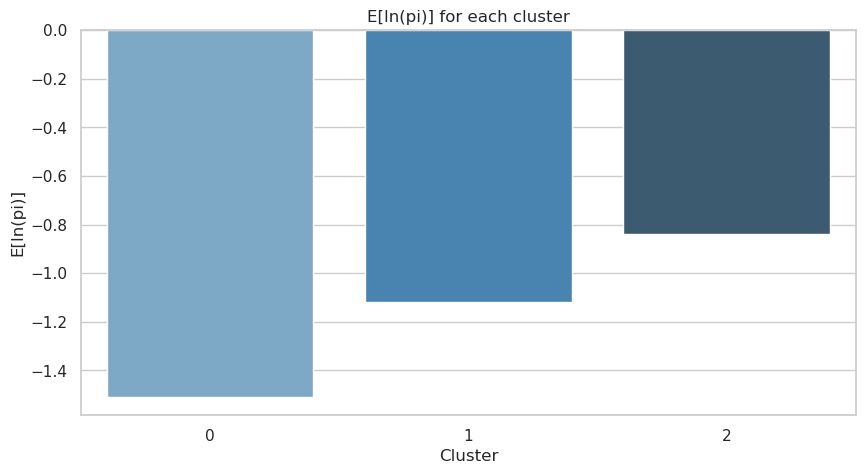

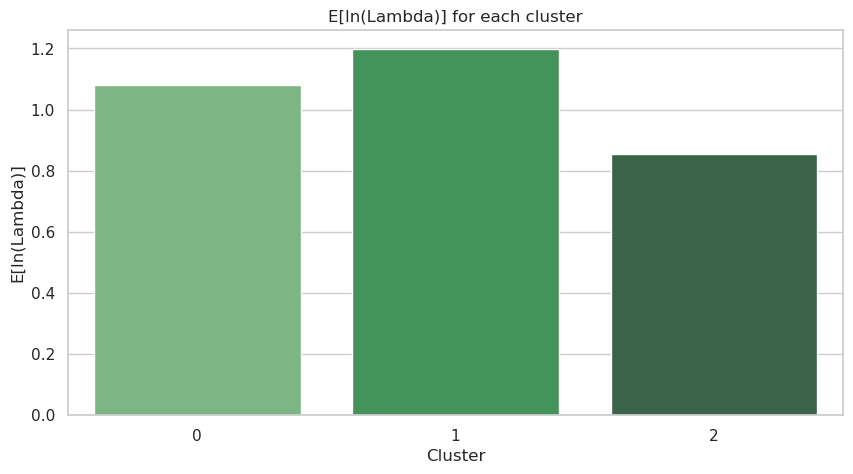

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Approximation of the digamma function using its series expansion
def digamma(x):
    """
    Approximate the digamma function using a series expansion and large x approximation.
    """
    if x <= 0:
        raise ValueError("Input to digamma must be positive.")
    
    result = 0
    # Shift x into the large range
    while x < 5:
        result -= 1 / x
        x += 1
    
    # Large x approximation
    result += np.log(x) - 0.5 / x - 1 / (12 * x**2)
    return result


# Function to calculate the log determinant of a matrix
def log_determinant(matrix):
    sign, logdet = np.linalg.slogdet(matrix)
    if sign <= 0:
        raise ValueError("Matrix is not positive definite.")
    return logdet

# Variational Bayesian GMM Update
def variational_bayesian_gmm_update(Nk, Sk, xk, alpha0, beta0, m0, W0, nu0):
    K = len(Nk)  # Number of clusters
    D = len(m0)  # Dimensionality of data

    # Initialize updated parameters
    alpha = [alpha0 + Nk[k] for k in range(K)]
    beta = [beta0 + Nk[k] for k in range(K)]
    m = []
    W = []
    nu = [nu0 + Nk[k] for k in range(K)]

    for k in range(K):
        # Update mean
        mk = (beta0 * m0 + Nk[k] * xk[k]) / beta[k]
        m.append(mk)

        # Update scale matrix
        xk_diff = xk[k] - m0
        Wk_inv = (np.linalg.inv(W0)
                  + Nk[k] * Sk[k]
                  + (beta0 * Nk[k] / (beta0 + Nk[k])) * np.outer(xk_diff, xk_diff))
        Wk = np.linalg.inv(Wk_inv)
        W.append(Wk)

    return alpha, beta, m, W, nu

# Compute Expectations
def compute_expectations(alpha, beta, m, W, nu):
    K = len(alpha)
    D = len(m[0])

    # Initialize expectations
    E_ln_pi = [digamma(alpha[k]) - digamma(sum(alpha)) for k in range(K)]
    E_ln_Lambda = []

    for k in range(K):
        psi_terms = sum(digamma((nu[k] + 1 - i) / 2) for i in range(1, D + 1))
        ln_det = log_determinant(W[k])
        E_ln_Lambda_k = psi_terms + D * np.log(2) + ln_det
        E_ln_Lambda.append(E_ln_Lambda_k)

    return E_ln_pi, E_ln_Lambda

# Visualization with Seaborn
def plot_expectations(E_ln_pi, E_ln_Lambda):
    sns.set(style="whitegrid")

    # Bar plot for E[ln(pi)]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=np.arange(len(E_ln_pi)), y=E_ln_pi, palette="Blues_d")
    plt.title("E[ln(pi)] for each cluster")
    plt.xlabel("Cluster")
    plt.ylabel("E[ln(pi)]")
    plt.show()

    # Bar plot for E[ln(Lambda)]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=np.arange(len(E_ln_Lambda)), y=E_ln_Lambda, palette="Greens_d")
    plt.title("E[ln(Lambda)] for each cluster")
    plt.xlabel("Cluster")
    plt.ylabel("E[ln(Lambda)]")
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example parameters
    K = 3  # Number of clusters
    D = 2  # Dimensionality
    alpha0 = 1.0
    beta0 = 1.0
    m0 = np.zeros(D)
    W0 = np.eye(D)
    nu0 = D

    # Mock data
    Nk = [10, 15, 20]
    Sk = [np.eye(D) * 0.5 for _ in range(K)]
    xk = np.random.randn(K, D)

    # Perform updates
    alpha, beta, m, W, nu = variational_bayesian_gmm_update(Nk, Sk, xk, alpha0, beta0, m0, W0, nu0)

    # Compute expectations
    E_ln_pi, E_ln_Lambda = compute_expectations(alpha, beta, m, W, nu)

    # Plot expectations
    plot_expectations(E_ln_pi, E_ln_Lambda)


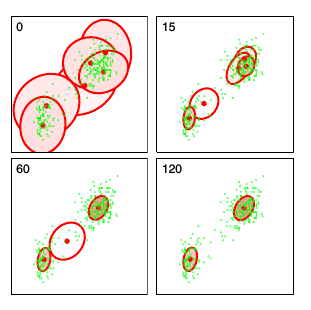

Fig.6 Variational Bayesian mixture of K = 6 Gaussians ap- plied to the Old Faithful data set, in which the ellipses denote the one standard-deviation density contours for each of the components, and the density of red ink inside each ellipse corresponds to the mean value of the mixing coefﬁcient for each com- ponent. The number in the top left of each diagram shows the num- ber of iterations of variational infer- ence. Components whose expected mixing coefﬁcient are numerically in- distinguishable from zero are not plotted.

# Variational Bayesian Gaussian Mixture Model

## Responsibilities and Updates

Using the definitions of $ \Lambda_k $ and $\pi$, and the digamma function $ \psi(\cdot) $ (defined by Equation B.25), we have:
$$
\alpha = \sum_k \alpha_k
$$

The results in Equations (10.65) and (10.66) follow from the standard properties of the Wishart and Dirichlet distributions. Substituting Equations (10.64), (10.65), and (10.66) into Equation (10.46) and using Equation (10.49), we get the responsibilities:
$$
r_{nk} \propto \pi_k \Lambda_k^{1/2} \exp \left( 
    - \frac{D}{2 \beta_k} 
    - \frac{\nu_k}{2} (\mathbf{x}_n - \mathbf{m}_k)^T \mathbf{W}_k (\mathbf{x}_n - \mathbf{m}_k) 
\right)
\tag{10.67}
$$

For comparison, the responsibilities from the maximum likelihood EM are given by:
$$
r_{nk} \propto \pi_k |\Lambda_k|^{1/2} \exp \left(
    - \frac{1}{2} (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \Lambda_k (\mathbf{x}_n - \boldsymbol{\mu}_k)
\right)
\tag{10.68}
$$

This shows the similarity to the responsibilities in maximum likelihood EM, with precision replacing covariance for clarity.

## Variational Bayesian Updates

The optimization of the variational posterior involves alternating steps akin to the E and M steps of maximum likelihood EM:

1. **Variational E-step**: Use current parameter distributions to evaluate moments:
   - $E[z_{nk}] = r_{nk}$

2. **Variational M-step**: Fix the responsibilities and recompute the variational distributions using:
   - $(10.57)$
   - $(10.59)$

### Mixing Coefficients
For the mixing coefficients, the expected value in the posterior distribution is given by:
$$
E[\pi_k] = \frac{\alpha_k + N_k}{K \alpha_0 + N}
\tag{10.69}
$$

For components with $N_k \to 0$ and $\alpha_k \to \alpha_0$:

- If $\alpha_0 \to 0$ (broad prior): $E[\pi_k] \to 0$
- If $\alpha_0 \to \infty$ (tight prior): $E[\pi_k] \to \frac{1}{K}$

## Insights and Observations

- The Bayesian approach avoids singularities encountered in maximum likelihood, such as when a Gaussian component collapses onto a data point.
- Overfitting is mitigated by Bayesian regularization, even with a large number of components $K$.
- Variational methods can determine the optimal number of components without cross-validation.

### Computational Considerations

- The dominant cost lies in evaluating the responsibilities and inverting weighted data covariance matrices, similar to maximum likelihood EM.
- The Bayesian treatment provides robustness against singularities and overfitting, offering advantages over traditional maximum likelihood methods.

### Example: Old Faithful Data
Figure 10.6 illustrates applying this approach to rescaled Old Faithful data for a Gaussian mixture model with $K=6$ components. The ellipses denote one standard-deviation contours for each component. Components with numerically indistinguishable mixing coefficients from prior values are not plotted.

- For $\alpha_0 = 10^{-3}$: Two components remain active.
- For $\alpha_0 = 1$: Three components remain active.
- For $\alpha_0 = 10$: All six components remain active.

This illustrates how prior constraints influence model complexity.

### Reference: Fig.6
The diagram highlights the Bayesian trade-off between data fitting and model complexity. Broader priors favor sparsity, whereas tighter priors distribute mixing coefficients evenly.


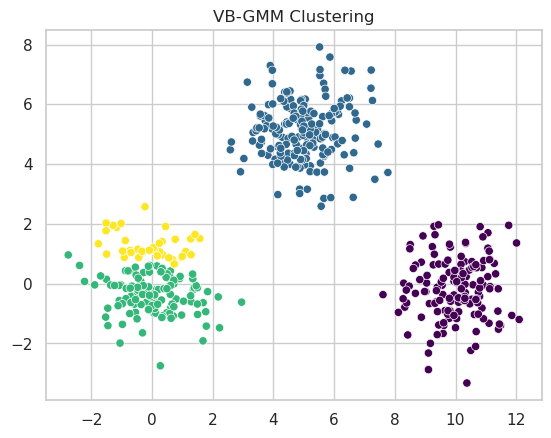

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def digamma(x):
    if x <= 0:
        raise ValueError("Input to digamma must be positive.")
    result = 0
    while x < 5:
        result -= 1 / x
        x += 1
    result += np.log(x) - 0.5 / x - 1 / (12 * x**2)
    return result

def log_wishart(W, nu, D):
    term1 = np.sum([digamma((nu + 1 - i) / 2) for i in range(1, D + 1)])
    term2 = D * np.log(2)
    term3 = np.linalg.slogdet(W)[1]
    return term1 + term2 + term3

def generate_data(N, centers, covariances, weights):
    data = []
    for i in range(N):
        k = np.random.choice(len(weights), p=weights)
        sample = np.random.multivariate_normal(centers[k], covariances[k])
        data.append(sample)
    return np.array(data)

class VariationalBayesianGMM:
    def __init__(self, K, D, alpha_0, beta_0, m_0, W_0, nu_0):
        self.K = K
        self.D = D
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.m_0 = m_0
        self.W_0 = W_0
        self.nu_0 = nu_0

    def initialize(self, X):
        N, D = X.shape
        self.N = N
        self.rnk = np.random.dirichlet(np.ones(self.K), size=N)
        self.alpha = np.full(self.K, self.alpha_0)
        self.beta = np.full(self.K, self.beta_0)
        self.m = np.random.randn(self.K, D)
        self.W = np.tile(np.linalg.inv(self.W_0), (self.K, 1, 1))
        self.nu = np.full(self.K, self.nu_0)

    def compute_expectations(self):
        E_ln_pi = [digamma(self.alpha[k]) - digamma(np.sum(self.alpha)) for k in range(self.K)]
        E_ln_Lambda = [log_wishart(self.W[k], self.nu[k], self.D) for k in range(self.K)]
        return np.array(E_ln_pi), np.array(E_ln_Lambda)

    def update_parameters(self, X):
        Nk = np.sum(self.rnk, axis=0)
        xk = np.dot(self.rnk.T, X) / Nk[:, None]
        Sk = np.zeros((self.K, self.D, self.D))
        for k in range(self.K):
            diff = X - xk[k]
            Sk[k] = np.einsum('ni,nj->ij', diff * self.rnk[:, k][:, None], diff) / Nk[k]

        self.alpha = self.alpha_0 + Nk
        self.beta = self.beta_0 + Nk
        self.m = (self.beta_0 * self.m_0 + Nk[:, None] * xk) / self.beta[:, None]
        for k in range(self.K):
            diff = xk[k] - self.m_0
            self.W[k] = np.linalg.inv(
                np.linalg.inv(self.W_0) + Nk[k] * Sk[k] + 
                (self.beta_0 * Nk[k]) / (self.beta_0 + Nk[k]) * np.outer(diff, diff)
            )
        self.nu = self.nu_0 + Nk

    def update_responsibilities(self, X):
        E_ln_pi, E_ln_Lambda = self.compute_expectations()
        ln_rnk = np.zeros((self.N, self.K))
        for k in range(self.K):
            diff = X - self.m[k]
            ln_rnk[:, k] = (
                E_ln_pi[k] + 0.5 * E_ln_Lambda[k] 
                - 0.5 * self.D / self.beta[k]
                - 0.5 * self.nu[k] * np.einsum('ni,ij,nj->n', diff, self.W[k], diff)
            )
        ln_rnk -= np.max(ln_rnk, axis=1, keepdims=True)  # For numerical stability
        self.rnk = np.exp(ln_rnk)
        self.rnk /= np.sum(self.rnk, axis=1, keepdims=True)

    def fit(self, X, max_iter=100, tol=1e-6):
        self.initialize(X)
        prev_rnk = np.zeros_like(self.rnk)
        for i in range(max_iter):
            self.update_responsibilities(X)
            self.update_parameters(X)
            if np.linalg.norm(self.rnk - prev_rnk) < tol:
                break
            prev_rnk = self.rnk.copy()

# Generate synthetic data
centers = [[0, 0], [5, 5], [10, 0]]
covariances = [np.eye(2) for _ in centers]
weights = [0.3, 0.4, 0.3]
X = generate_data(500, centers, covariances, weights)

# Fit VB-GMM
K = 6
vb_gmm = VariationalBayesianGMM(K=K, D=2, alpha_0=1.0, beta_0=1.0, m_0=np.zeros(2), W_0=np.eye(2), nu_0=3)
vb_gmm.fit(X)

# Visualize
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.argmax(vb_gmm.rnk, axis=1), palette='viridis', legend=None)
plt.title('VB-GMM Clustering')
plt.show()
